<a href="https://colab.research.google.com/github/rafaeljosem/MNA-ProyectoIntegrador_EQ10/blob/main/Copy_of_JSON_creation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

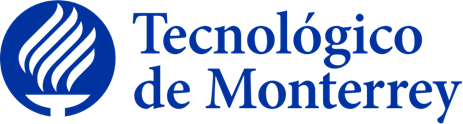

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

### Domingo 19 de mayo de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

### 1. Libraries

First, we'll install and load the libraries that we will be using for this project.

In [3]:
#Let's install a couple of libraries that we'll use
%%capture
!pip install -q -U google-generativeai
!pip install python-dotenv

In [5]:
import os
import google.generativeai as genai
#%load_ext cudf.pandas
import pandas as pd
from dotenv import load_dotenv
from zipfile import ZipFile
import requests
import re
import json
import time
from requests.exceptions import RequestException
from google.colab import userdata
import tqdm
from collections import defaultdict
from rich import print
import traceback

### 2. Helper Functions

We also define a few helper functions that we'll use for downloading, reading text, etc.

### 3. Prepare the dataset

Now we'll proceed to download the dataset we will be using and load the content to a list of dictionaries.

In [6]:

#The corpus is encoded as latin1, so we must decode it first
def decode_text(text: str) -> str:
    try:
        return text.encode("latin_1").decode("utf-8")
    except UnicodeDecodeError:
        return text.encode("latin_1").decode("utf-8", errors="replace")

#This method removes newlines so it's easier to extract the title
def remove_new_lines(lines: list) -> list:
    clean_text = []
    for line in lines:
        if not isinstance(line, str):
            continue
        line = line.strip(' ')
        if line == '':
            continue

        clean_text.append(decode_text(line))

    return clean_text

#This method reads the files and execute the methods above
def read_file(file_name:str):
    with open(file_name, encoding='latin_1') as f:
        text = f.read().splitlines()
        clean_text = remove_new_lines(text)
        if len(text) != 0:
            title = clean_text[0]
        return (title, decode_text("\n".join(text)))

#Extracts the filename from the response
def extract_filename(r:requests.Response) -> str:
    if "Content-Disposition" in r.headers.keys():
        return re.findall("filename=(.+)",
                          r.headers["Content-Disposition"])[0]
    else:
        return r.url.split("/")[-1]

#Downloads a file
def download_files(urls: list, directory: str):
    filenames = []
    if not os.path.exists(directory):
        os.mkdir(directory)
    for url in urls:
        try:
            with requests.get(url) as r:
                filename = extract_filename(r)
                filenames.append(filename)
                file = open(f'{directory}/{filename}', mode="wb")
                file.write(r.content)
                file.close()
        except RequestException as e:
            print(e)
    return filenames[0] if len(filenames) == 1 else filenames

#Unzips a file
def unzip(filename: str, source_path: str, dest_path: str):
    if not os.path.exists(dest_path):
        os.mkdir(dest_path)
    with ZipFile(f'{source_path}/{filename}', 'r') as zObject:
        zObject.extractall(path=dest_path)

In [7]:
#This is the URL where the dataset for this notebook will be downloaded from
url = 'https://github.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/raw/main/small_dataset.zip'

In [8]:
filename = download_files([url], './')
unzip(filename, './', './tmp')

In [9]:
corpus = []

# Let's get the content from every file in the directory
for path, folders, files in os.walk('./tmp'):
    for file in files:
        if file.endswith('.txt'):
            title ,text =  read_file(os.path.join(path, file))

            corpus.append({
                'Title': title,
                'Filename': file,
                'Text': text
            })

In [10]:
print(f'Total number of documents: {len(corpus)}')

Total number of documents: 11

In [11]:
# Print first 10 lines
for line in corpus[0]['Text'].splitlines()[55:70]:
  print(line)


Nueva Ley publicada en el Diario Oficial de la Federaci�n el 8 de octubre de 2003

TEXTO VIGENTE

�ltima reforma publicada DOF 19-01-2018

Al margen un sello con el Escudo Nacional, que dice: Estados Unidos Mexicanos.- Presidencia de la

Rep�blica.

VICENTE FOX QUESADA, Presidente de los Estados Unidos Mexicanos, a sus habitantes sabed:

### 4. Instruction set generation

We'll generate the instruction set that will be used to finetune the model. Since generating instruction datasets is a high-intensive work, we will use Gemini 1.5 to speed up the process. The main drawback of this method is that the generated instructions will not be of high quality, which will have some impact when finetuning our model.

For future work it would be beneficial to generate high-quality instructions using domain experts.

On some other note, we use Google Gemini because is the model that supports the longest context window (currently 1 millon tokens). Other models are way below this number, which means that providing the full text of the documents would have been problematic.

Finally, in our previous deliverable we stated that we would use Bonito, a LLM for generating instrution sets. Nonetheless, after carefully reading the documentation we found that Bonito only supports the english language. Since our corpus is in spanish, the use of Bonito is not viable.

In [12]:
#We need a API key. Please, be sure to have a .env file in the same directory of this notebook.
load_dotenv()
# GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
os.environ['GEMINI_API_KEY'] = GEMINI_API_KEY

In [13]:
genai.configure(api_key=GEMINI_API_KEY)

In [14]:
# Create the model
# See https://ai.google.dev/api/python/google/generativeai/GenerativeModel

generation_config = {
  "temperature": 1.5,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 8192,
  "response_mime_type": "application/json",
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE",
  },
]

Below we define our prompt for Google Gemini

In [15]:
prompt_1 = """
Eres un experto en inteligencia artificial, trabajas en el desarrollo de Large Language Models. Estás encargado del desarrollo de un modelo de lenguaje experto en el dominio de las leyes mexicanas, para lo cual estás creando un dataset de tipo instruction tuning. Hasta el momento, has recabado más de 300 leyes mexicanas, de las cuales requieres extraer información relevante y generar el dataset con preguntas y respuestas basados en los documentos legislativos.

Te estoy compartiendo la primera ley, vas a analizarla, entender la estructura general el documento, y vas a generar un JSON donde cada registro contenga información de un artículo, y donde cada registro contenga:

'ley': Se refiere al nombre de la ley, por ejemplo, "Código Federal de Procedimientos Civiles"
'libro_no': Se refiere al número de libro al que pertenece, por ejemplo, "LIBRO SEGUNDO"
'libro_nombre': Se refiere al nombre del libro, por ejemplo, "De los Bienes"
'titulo_no' Se refiere al número de título, por ejemplo, "TITULO SEGUNDO"
'titulo_nombre' Se refiere al nombre del título, por ejemplo, "De la Sucesión por Testamento"
'capitulo_no': Se refiere al número de capítulo (solo si aplica, en caso de no pertenecer a un capítulo, declarar "N/A"), por ejemplo, "CAPITULO I"
'capitulo_nombre': Se refiere al nombre del capítulo, por ejemplo, "De los Testamentos en General"
'articulo_no': Se refiere al número de artículo, por ejemplo, "Artículo 1413
'articulo_contenido': Se refiere al contenido del artículo, por ejemplo, "Queda también sin efecto el legado, si el testador enajena la cosa legada; pero vale si la recobra por un título legal."

Por ejemplo:
[
  {
    "ley": "Código Civil Federal",
    "libro_no": "LIBRO TERCERO",
    "libro_nombre": "De las Sucesiones",
    "titulo_no": "TITULO SEGUNDO",
    "titulo_nombre": "De la Sucesión por Testamento",
    "capitulo_no": "CAPITULO I",
    "capitulo_nombre": "N/A",
    "articulo_no": "Artículo 1295",
    "articulo_contenido": "Testamento es un acto personalísimo, revocable y libre, por el cual una persona capaz dispone de sus bienes y derechos, y declara o cumple deberes para después de su muerte."
  }
]

Dado un documento legal de tipo código, ley, decreto, reglamento o similar, extrae un JSON con 5 registros.
Cada registro representa un artículo del documento; elige los artículos de forma aleatoria, pero distribuida; es decir, busca representa artículos ubicados en distintos libros, títulos o capítulos del documento.
"""

In [16]:
model = genai.GenerativeModel(
  model_name="gemini-1.5-flash-latest",
  safety_settings=safety_settings,
  generation_config=generation_config,
  system_instruction=prompt_1,
)

In [17]:
# CELDA DE PRUEBA

# Use the environment variable in the bash script
%%bash

curl -H 'Content-Type: application/json' \
    -d '{"contents":[{"parts":[{"text":"What is the meaning of life"}]}]}' \
    -X POST "https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?key=$GEMINI_API_KEY"

{
  "candidates": [
    {
      "content": {
        "parts": [
          {
            "text": "**Philosophical Perspectives:**\n\n* **Existentialism:** Meaning is subjective and created by individuals through their actions and experiences.\n* **Hedonism:** The pursuit of pleasure and avoidance of pain is the ultimate meaning.\n* **Utilitarianism:** Maximizing happiness and minimizing suffering for all beings is the greatest good.\n* **Stoicism:** Acceptance of fate and focus on virtue, leading to a meaningful and fulfilling life.\n* **Transcendentalism:** Meaning comes from connecting with the natural world and experiencing spiritual enlightenment.\n\n**Religious Perspectives:**\n\n* **Christianity:** Meaning is found in serving God and following his teachings, resulting in eternal life.\n* **Islam:** Meaning is derived from worshipping Allah and adhering to the principles of Islam.\n* **Hinduism:** Meaning lies in the cycle of birth, death, and rebirth, seeking enlightenment and lib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2978    0  2913  100    65    447      9  0:00:07  0:00:06  0:00:01   677


In [18]:
history = [
    {
      "role": "user",
      "parts": [
        "¿Quién eres?",
      ],
    },
    {
      "role": "model",
      "parts": [
        "Soy un experto en inteligencia artificial, trabajo en el desarrollo de Large Language Models.",
      ],
    },
  ]

We now loop through every document and send the prompt and the document text to Google Gemini. Sometimes, Google Gemini might throw a recitation error. The reason of why this occurs is not entirely known, but it seems that some content is being flagged for unauthorized citations.

Please, be aware that the following step might take around 10-15 minutes to execute.

In [19]:
# CELDA DE PRUEBA
chat_session = genai.ChatSession(
    model=model
)

msg = "Extrae el JSON para el siguiente documento:\n---\n" + corpus[0]['Text'] + "---"

response = chat_session.send_message(msg)

In [20]:
# CELDA DE PRUEBA
#print(response.text)
result = re.sub(r"(json\n|`{3})", "", response.text, 0, re.MULTILINE)
json_output = json.loads(result)
print(type(json_output[0]))

<class 'dict'>

In [25]:
outputs = {}
errors = []

with tqdm.tqdm(total=len(corpus), desc="Procesando leyes") as pbar:
  for item in corpus[0:3]:
    try:
      chat_session = model.start_chat()
      msg = "Extrae el JSON para la siguiente ley:\n---\n" + \
        item['Text'] + "---"
      json_output = chat_session.send_message(msg)
      #Let's format the output to get a valid json
      result = re.sub(r"(json\n|`{3})", "",
                        json_output.text, 0, re.MULTILINE)
      outputs[item['Title']] = json.loads(result)

    #Sometimes Google Gemini might throw a recitation error
    except Exception as e:
        errors.append(
            {'title': item['Title'],
             'error': type(e).__name__,
             'error_msg': str(e)})
    finally:
            pbar.update(1)

Procesando leyes:  27%|██▋       | 3/11 [02:01<05:25, 40.65s/it]


In [26]:
print(f'Number of files processed correctly: {len(outputs)}\n'\
    f'Number of files with errors: {len(errors)}')

Number of files processed correctly: 3
Number of files with errors: 0

In [27]:
print(outputs)

{
    'Ley General para la Prevenci�n y Gesti�n Integral de los Residuos': [
        {
            'ley': 'Ley General para la Prevenci�n y Gesti�n Integral de los Residuos',
            'libro_no': 'N/A',
            'libro_nombre': 'N/A',
            'titulo_no': 'T�TULO PRIMERO',
            'titulo_nombre': 'DISPOSICIONES GENERALES',
            'capitulo_no': 'CAP�TULO �NICO',
            'capitulo_nombre': 'OBJETO Y �MBITO DE APLICACI�N DE LA LEY',
            'articulo_no': 'Art�culo 1',
            'articulo_contenido': 'La presente Ley es reglamentaria de las disposiciones de la Constituci�n 
Pol�tica de los Estados Unidos Mexicanos que se refieren a la protecci�n al ambiente en materia de prevenci�n y 
gesti�n integral de residuos, en el territorio nacional.'
        },
        {
            'ley': 'Ley General para la Prevenci�n y Gesti�n Integral de los Residuos',
            'libro_no': 'N/A',
            'libro_nombre': 'N/A',
            'titulo_no': 'T�TULO SEGUNDO',
            'titulo_nombre': 'DISTRIBUCI�N DE COMPETENCIAS Y COORDINACI�N',
            'capitulo_no': 'CAP�TULO �NICO',
            'capitulo_nombre': 'ATRIBUCIONES DE LOS TRES �RDENES DE GOBIERNO Y COORDINACI�N ENTRE DEPENDENCIAS',
            'articulo_no': 'Art�culo 6',
            'articulo_contenido': 'La Federaci�n, las entidades federativas y los municipios, ejercer�n sus 
atribuciones en materia de prevenci�n de la generaci�n, aprovechamiento, gesti�n integral de los residuos, de 
prevenci�n de la contaminaci�n de sitios y su remediaci�n, de conformidad con la distribuci�n de competencias 
prevista en esta Ley y en otros ordenamientos legales.'
        },
        {
            'ley': 'Ley General para la Prevenci�n y Gesti�n Integral de los Residuos',
            'libro_no': 'N/A',
            'libro_nombre': 'N/A',
            'titulo_no': 'T�TULO TERCERO',
            'titulo_nombre': 'CLASIFICACI�N DE LOS RESIDUOS',
            'capitulo_no': 'CAP�TULO �NICO',
            'capitulo_nombre': 'FINES, CRITERIOS Y BASES GENERALES',
            'articulo_no': 'Art�culo 15',
            'articulo_contenido': 'La Secretar�a agrupar� y subclasificar� los residuos peligrosos, s�lidos urbanos
y de manejo especial en categor�as, con el prop�sito de elaborar los inventarios correspondientes, y orientar la 
toma de decisiones basada en criterios de riesgo y en el manejo de los mismos. La subclasificaci�n de los residuos 
deber� atender a la necesidad de:'
        },
        {
            'ley': 'Ley General para la Prevenci�n y Gesti�n Integral de los Residuos',
            'libro_no': 'N/A',
            'libro_nombre': 'N/A',
            'titulo_no': 'T�TULO CUARTO',
            'titulo_nombre': 'INSTRUMENTOS DE LA POL�TICA DE PREVENCI�N Y GESTI�N INTEGRAL DE LOS RESIDUOS',
            'capitulo_no': 'CAP�TULO I',
            'capitulo_nombre': 'PROGRAMAS PARA LA PREVENCI�N Y GESTI�N INTEGRAL DE LOS RESIDUOS',
            'articulo_no': 'Art�culo 25',
            'articulo_contenido': 'La Secretar�a deber� formular e instrumentar el Programa Nacional para la 
Prevenci�n y Gesti�n Integral de los Residuos, de conformidad con esta Ley, con el Diagn�stico B�sico para la 
Gesti�n Integral de Residuos y dem�s disposiciones aplicables.'
        },
        {
            'ley': 'Ley General para la Prevenci�n y Gesti�n Integral de los Residuos',
            'libro_no': 'N/A',
            'libro_nombre': 'N/A',
            'titulo_no': 'T�TULO QUINTO',
            'titulo_nombre': 'MANEJO INTEGRAL DE RESIDUOS PELIGROSOS',
            'capitulo_no': 'CAP�TULO VI',
            'capitulo_nombre': 'LA PRESTACI�N DE SERVICIOS EN MATERIA DE RESIDUOS PELIGROSOS',
            'articulo_no': 'Art�culo 80',
            'articulo_contenido': 'Las personas interesadas en obtener autorizaciones para llevar a cabo los 
servicios a terceros para el transporte, acopio, almacenamiento, reutilizaci�n, reciclaje, tratamiento y 
disposici�n final de residuos, seg�n sea el caso

In [28]:
print(errors)

[]

### Parte 2 del flujo

In [29]:
prompt_2 = """Tomando en cuenta el contenido de la ley compartida a continación, por favor genera 5 ejemplos de plantillas de tipo "Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting", siguiendo el formato de pares instruction-output. Ejemplo de Question Answering (QA): [ { "instruction": "Según el artículo 22 del Código Civil Federal, ¿desde qué momento entra el individuo concebido bajo la protección de la ley?", "output": "De acuerdo al artículo 22 del Código Civil Federal, desde el momento en que un individuo es concebido, entra bajo la protección de la ley y se le tiene por nacido para los efectos declarados en el presente Código." }, { "instruction": "¿Qué establece el artículo 23 del Código Civil Federal sobre el ejercicio de derechos de los incapaces?", "output": "Según el artículo 23 del Código Civil Federal, la minoría de edad, el estado de interdicción y demás incapacidades establecidas por la ley, son restricciones a la personalidad jurídica que no deben menoscabar la dignidad de la persona ni atentar contra la integridad de la familia; pero los incapaces pueden ejercitar sus derechos o contraer obligaciones por medio de sus representantes." } ] Ejemplos de Summarization: [ { "instruction": "Resume las obligaciones del Juez del Registro Civil respecto a las actas, según los artículos 43 a 49 del Código Civil Federal.", "output": "De acuerdo a los artículos 43 a 49 del Código Civil Federal, el Juez del Registro Civil tiene las siguientes obligaciones respecto a las actas: asentar sólo lo declarado para el acto y previsto en la ley; permitir la representación por mandatario especial; preferir testigos designados por los interesados; evitar falsificación o inserción de circunstancias prohibidas; corregir vicios o defectos no sustanciales; dar testimonio de actas; y autorizar actas de su propia familia en la adscripción más próxima." }, { "instruction": "Sintetiza lo que establece el Código Civil Federal en los artículos del 86 al 88 sobre la adopción plena.", "output": "Los artículos 86, 87 y 88 del Código Civil Federal establecen que en la adopción plena se levantará un acta como si fuera de nacimiento, se harán anotaciones en el acta de nacimiento originaria, la cual quedará reservada. No se publicará ni expedirá constancia alguna que revele el origen del adoptado ni su condición, salvo providencia judicial. El artículo 88 fue derogado." } ] Ejemplos de Legal Advice Generation: [ { "instruction": "Si dos personas quieren contraer matrimonio siendo menores de edad, ¿qué requisitos deben cumplir según el Código Civil Federal?", "output": "De acuerdo al Código Civil Federal, si dos personas menores de edad quieren contraer matrimonio, deben cumplir los siguientes requisitos: 1) Tener al menos 16 años el hombre y 14 la mujer (art. 148); 2) Obtener el consentimiento de sus padres, abuelos paternos o tutores (arts. 149-155); 3) Solicitar la dispensa del juez de lo familiar (art. 151); 4) Presentar su solicitud ante el Juez del Registro Civil (art. 97) con la documentación requerida (art. 98). Se recomienda consultar a un abogado especializado para recibir orientación específica a su caso." }, { "instruction": "¿Qué pasos debe seguir una persona para solicitar una acta de nacimiento según el Código Civil Federal?", "output": "Para solicitar un acta de nacimiento, el Código Civil Federal establece en sus artículos 54 a 76 el siguiente procedimiento: 1) Presentar al recién nacido ante el Juez del Registro Civil en su oficina o lugar de nacimiento; 2) Los padres o abuelos declaran el nacimiento dentro de los 6 meses siguientes; 3) Si nace en casa, el jefe de familia tiene obligación de dar aviso; 4) Si nace en un sanatorio,el director o administrador dará aviso; 5) Se levantará el acta de nacimiento con asistencia de dos testigos, expresándose todos los datos requeridos por la ley. Es importante cumplir los plazos y proporcionar información veraz para evitar contratiempos posteriores." } ] Ejemplos de Legal Document Drafting: [ { "instruction": "Redacta una cláusula para un contrato de compraventa de un inmueble, estipulando que las partes se someten a las leyes mexicanas según el Código Civil Federal.", "output": "CLÁUSULA DÉCIMA.- LEY APLICABLE. Para todo lo relativo a la interpretación, cumplimiento y ejecución del presente contrato, las partes acuerdan someterse a las leyes federales de los Estados Unidos Mexicanos, en particular a las disposiciones del Código Civil Federal, según lo establecido en sus artículos 12, 13 y demás relativos y aplicables, renunciando expresamente a cualquier otra ley, fuero o jurisdicción que pudiera corresponderles en virtud de sus domicilios presentes o futuros." }, { "instruction": "Elabora una cláusula para un contrato de arrendamiento especificando que la renta se incrementará anualmente conforme al Código Civil Federal.", "output": "CLÁUSULA DÉCIMA.- INCREMENTO DE LA RENTA. Las partes acuerdan que la renta pactada en la cláusula X del presente contrato se incrementará anualmente de manera automática, aplicando el porcentaje de aumento que corresponda al Índice Nacional de Precios al Consumidor (INPC) publicado por el Banco de México. Lo anterior con fundamento en lo dispuesto por el artículo 2448-J del Código Civil Federal. El arrendador notificará por escrito al arrendatario, con al menos 30 días de anticipación, el monto de la renta actualizada que entrará en vigor en la fecha de aniversario del contrato." } ] Por cada registro del JSON que te estoy compartiendo a continuación, genera un par instruction-output de cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting")."""

In [30]:
print(f"Prompt template: {prompt_2}")

Prompt template: Tomando en cuenta el contenido de la ley compartida a continación, por favor genera 5 ejemplos de 
plantillas de tipo "Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document 
Drafting", siguiendo el formato de pares instruction-output. Ejemplo de Question Answering (QA): [ { "instruction":
"Según el artículo 22 del Código Civil Federal, ¿desde qué momento entra el individuo concebido bajo la protección 
de la ley?", "output": "De acuerdo al artículo 22 del Código Civil Federal, desde el momento en que un individuo es
concebido, entra bajo la protección de la ley y se le tiene por nacido para los efectos declarados en el presente 
Código." }, { "instruction": "¿Qué establece el artículo 23 del Código Civil Federal sobre el ejercicio de derechos
de los incapaces?", "output": "Según el artículo 23 del Código Civil Federal, la minoría de edad, el estado de 
interdicción y demás incapacidades establecidas por la ley, son restricciones a la personalidad jurídica que no 
deben menoscabar la dignidad de la persona ni atentar contra la integridad de la familia; pero los incapaces pueden
ejercitar sus derechos o contraer obligaciones por medio de sus representantes." } ] Ejemplos de Summarization: [ {
"instruction": "Resume las obligaciones del Juez del Registro Civil respecto a las actas, según los artículos 43 a 
49 del Código Civil Federal.", "output": "De acuerdo a los artículos 43 a 49 del Código Civil Federal, el Juez del 
Registro Civil tiene las siguientes obligaciones respecto a las actas: asentar sólo lo declarado para el acto y 
previsto en la ley; permitir la representación por mandatario especial; preferir testigos designados por los 
interesados; evitar falsificación o inserción de circunstancias prohibidas; corregir vicios o defectos no 
sustanciales; dar testimonio de actas; y autorizar actas de su propia familia en la adscripción más próxima." }, { 
"instruction": "Sintetiza lo que establece el Código Civil Federal en los artículos del 86 al 88 sobre la adopción 
plena.", "output": "Los artículos 86, 87 y 88 del Código Civil Federal establecen que en la adopción plena se 
levantará un acta como si fuera de nacimiento, se harán anotaciones en el acta de nacimiento originaria, la cual 
quedará reservada. No se publicará ni expedirá constancia alguna que revele el origen del adoptado ni su condición,
salvo providencia judicial. El artículo 88 fue derogado." } ] Ejemplos de Legal Advice Generation: [ { 
"instruction": "Si dos personas quieren contraer matrimonio siendo menores de edad, ¿qué requisitos deben cumplir 
según el Código Civil Federal?", "output": "De acuerdo al Código Civil Federal, si dos personas menores de edad 
quieren contraer matrimonio, deben cumplir los siguientes requisitos: 1) Tener al menos 16 años el hombre y 14 la 
mujer (art. 148); 2) Obtener el consentimiento de sus padres, abuelos paternos o tutores (arts. 149-155); 3) 
Solicitar la dispensa del juez de lo familiar (art. 151); 4) Presentar su solicitud ante el Juez del Registro Civil
(art. 97) con la documentación requerida (art. 98). Se recomienda consultar a un abogado especializado para recibir
orientación específica a su caso." }, { "instruction": "¿Qué pasos debe seguir una persona para solicitar una acta 
de nacimiento según el Código Civil Federal?", "output": "Para solicitar un acta de nacimiento, el Código Civil 
Federal establece en sus artículos 54 a 76 el siguiente procedimiento: 1) Presentar al recién nacido ante el Juez 
del Registro Civil en su oficina o lugar de nacimiento; 2) Los padres o abuelos declaran el nacimiento dentro de 
los 6 meses siguientes; 3) Si nace en casa, el jefe de familia tiene obligación de dar aviso; 4) Si nace en un 
sanatorio,el director o administrador dará aviso; 5) Se levantará el acta de nacimiento con asistencia de dos 
testigos, expresándose todos los datos requeridos por la ley. Es importante cumplir los plazos y proporcionar 
información veraz para e

In [31]:
corpus_dict = outputs

In [32]:
model_2 = genai.GenerativeModel(
  model_name="gemini-1.5-flash-latest",
  safety_settings=safety_settings,
  generation_config=generation_config,
  system_instruction=prompt_2,
)

In [33]:
outputs2 = []
errors2 = []

with tqdm.tqdm(total=len(corpus_dict), desc="Procesando leyes") as pbar:
    for law, articles in corpus_dict.items():
        for article in articles:
            try:
                print(f"Processing law: {law}, article: {article['articulo_no']}")
                chat_session = model_2.start_chat()
                msg = f"""
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {json.dumps(article, ensure_ascii=False)}
                ---
                """
                print(f"Sending message: {msg}")
                response = chat_session.send_message(msg)
                response_text = response.text.strip()
                print(f"Received response: {response_text}")

                if response_text:
                    try:
                        instruction_output_pairs = json.loads(response_text)
                        outputs2.extend(instruction_output_pairs)
                        print(f"Parsed {len(instruction_output_pairs)} instruction-output pairs")
                    except json.JSONDecodeError as e:
                        print(f"Error parsing JSON: {str(e)}")
                        errors2.append({
                            'ley': law,
                            'articulo': article['articulo_no'],
                            'error': e,
                            'error_msg': str(e)
                        })
                else:
                    print("Empty response received")
                    errors2.append({
                        'ley': law,
                        'articulo': article['articulo_no'],
                        'error': 'Empty response',
                        'error_msg': 'The model returned an empty response'
                    })
            except Exception as e:
                print(f"Error processing law: {law}, article: {article['articulo_no']}")
                print(f"Error details: {str(e)}")
                print(f"Traceback: {traceback.format_exc()}")
                errors2.append({
                    'ley': law,
                    'articulo': article['articulo_no'],
                    'error': type(e).__name__,
                    'error_msg': str(e)
                })
            finally:
                pbar.update(1)

Procesando leyes:   0%|          | 0/3 [00:00<?, ?it/s]

Processing law: Ley General para la Prevenci�n y Gesti�n Integral de los Residuos, article: Art�culo 1

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley General para la Prevenci�n y Gesti�n Integral de los Residuos", "libro_no": "N/A", 
"libro_nombre": "N/A", "titulo_no": "T�TULO PRIMERO", "titulo_nombre": "DISPOSICIONES GENERALES", "capitulo_no": 
"CAP�TULO �NICO", "capitulo_nombre": "OBJETO Y �MBITO DE APLICACI�N DE LA LEY", "articulo_no": "Art�culo 1", 
"articulo_contenido": "La presente Ley es reglamentaria de las disposiciones de la Constituci�n Pol�tica de los 
Estados Unidos Mexicanos que se refieren a la protecci�n al ambiente en materia de prevenci�n y gesti�n integral de
residuos, en el territorio nacional."}
                ---

Error processing law: Ley General para la Prevenci�n y Gesti�n Integral de los Residuos, article: Art�culo 1

Error details: finish_reason: RECITATION
index: 0

Traceback: Traceback (most recent call last):
  File "<ipython-input-33-b25478f578c8>", line 20, in <cell line: 4>
    response = chat_session.send_message(msg)
  File "/usr/local/lib/python3.10/dist-packages/google/generativeai/generative_models.py", line 505, in 
send_message
    self._check_response(response=response, stream=stream)
  File "/usr/local/lib/python3.10/dist-packages/google/generativeai/generative_models.py", line 532, in 
_check_response
    raise generation_types.StopCandidateException(response.candidates[0])
google.generativeai.types.generation_types.StopCandidateException: finish_reason: RECITATION
index: 0

Procesando leyes:  33%|███▎      | 1/3 [00:07<00:14,  7.17s/it]

Processing law: Ley General para la Prevenci�n y Gesti�n Integral de los Residuos, article: Art�culo 6

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley General para la Prevenci�n y Gesti�n Integral de los Residuos", "libro_no": "N/A", 
"libro_nombre": "N/A", "titulo_no": "T�TULO SEGUNDO", "titulo_nombre": "DISTRIBUCI�N DE COMPETENCIAS Y 
COORDINACI�N", "capitulo_no": "CAP�TULO �NICO", "capitulo_nombre": "ATRIBUCIONES DE LOS TRES �RDENES DE GOBIERNO Y 
COORDINACI�N ENTRE DEPENDENCIAS", "articulo_no": "Art�culo 6", "articulo_contenido": "La Federaci�n, las entidades 
federativas y los municipios, ejercer�n sus atribuciones en materia de prevenci�n de la generaci�n, 
aprovechamiento, gesti�n integral de los residuos, de prevenci�n de la contaminaci�n de sitios y su remediaci�n, de
conformidad con la distribuci�n de competencias prevista en esta Ley y en otros ordenamientos legales."}
                ---

Received response: [{"instruction": "De acuerdo al artículo 6 de la Ley General para la Prevención y Gestión 
Integral de los Residuos, ¿quiénes tienen la responsabilidad de gestionar los residuos y cómo se distribuyen las 
competencias?", "output": "De acuerdo al artículo 6, la Federación, las entidades federativas y los municipios 
tienen la responsabilidad de gestionar los residuos. Las atribuciones se distribuyen de acuerdo con la Ley General 
para la Prevención y Gestión Integral de los Residuos y otros ordenamientos legales."}, {"instruction": "Resume la 
distribución de competencias en materia de gestión integral de residuos según el artículo 6 de la Ley General para 
la Prevención y Gestión Integral de los Residuos.", "output": "El artículo 6 de la Ley General para la Prevención y
Gestión Integral de los Residuos establece que la Federación, las entidades federativas y los municipios son 
responsables de la gestión de residuos. Sus atribuciones se basan en la distribución de competencias descrita en la
Ley y otros ordenamientos legales."}, {"instruction": "Si un municipio desea implementar un programa de reciclaje 
de residuos, ¿cómo se delimitan sus responsabilidades en relación a la Federación y los estados según la Ley 
General para la Prevención y Gestión Integral de los Residuos?", "output": "De acuerdo al artículo 6, los 
municipios tienen la responsabilidad de gestionar los residuos.  Para implementar un programa de reciclaje, deberán
coordinarse con la Federación y los estados, tomando en cuenta las atribuciones de cada nivel de gobierno y los 
ordenamientos legales que regulan la gestión integral de residuos.  Se recomienda consultar con las autoridades 
competentes en materia ambiental para garantizar el cumplimiento legal."}, {"instruction": "Elabora una cláusula 
para un contrato entre un municipio y una empresa privada que se encargue de la recolección de residuos, 
especificando que las responsabilidades de cada parte se sujetan a la Ley General para la Prevención y Gestión 
Integral de los Residuos.", "output": "CLÁUSULA X.- LEY APLICABLE: Ambas partes acuerdan sujetarse a las 
disposiciones de la Ley General para la Prevención y Gestión Integral de los Residuos, en particular al artículo 6,
para el cumplimiento de las obligaciones derivadas del presente contrato.  La gestión integral de los residuos se 
llevará a cabo de conformidad con la distribución de competencias establecida por la ley, y en el caso de las 
atribuciones del municipio, se ajustarán a las establecidas por la normativa local."}]

Parsed 4 instruction-output pairs

Procesando leyes:  67%|██████▋   | 2/3 [00:13<00:06,  6.66s/it]

Processing law: Ley General para la Prevenci�n y Gesti�n Integral de los Residuos, article: Art�culo 15

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley General para la Prevenci�n y Gesti�n Integral de los Residuos", "libro_no": "N/A", 
"libro_nombre": "N/A", "titulo_no": "T�TULO TERCERO", "titulo_nombre": "CLASIFICACI�N DE LOS RESIDUOS", 
"capitulo_no": "CAP�TULO �NICO", "capitulo_nombre": "FINES, CRITERIOS Y BASES GENERALES", "articulo_no": "Art�culo 
15", "articulo_contenido": "La Secretar�a agrupar� y subclasificar� los residuos peligrosos, s�lidos urbanos y de 
manejo especial en categor�as, con el prop�sito de elaborar los inventarios correspondientes, y orientar la toma de
decisiones basada en criterios de riesgo y en el manejo de los mismos. La subclasificaci�n de los residuos deber� 
atender a la necesidad de:"}
                ---

Received response: [
{"instruction": "De acuerdo al Artículo 15 de la Ley General para la Prevención y Gestión Integral de los Residuos,
¿con qué propósito la Secretaría agrupa y subclasifica los residuos peligrosos, sólidos urbanos y de manejo 
especial?", "output": "La Secretaría agrupa y subclasifica los residuos peligrosos, sólidos urbanos y de manejo 
especial en categorías para elaborar inventarios, orientar la toma de decisiones basadas en criterios de riesgo y 
facilitar la gestión de los residuos."},
{"instruction": "Resume el objetivo del Artículo 15 de la Ley General para la Prevención y Gestión Integral de los 
Residuos.", "output": "El Artículo 15 establece que la Secretaría agrupa y subclasifica los residuos en categorías 
para elaborar inventarios, tomar decisiones basadas en el riesgo y orientar la gestión de los residuos."},
{"instruction": "Si una empresa quiere clasificar sus residuos para cumplir con la Ley General para la Prevención y
Gestión Integral de los Residuos, ¿cómo debe proceder?", "output": "La Ley General para la Prevención y Gestión 
Integral de los Residuos establece que la Secretaría agrupa y subclasifica los residuos en categorías para 
facilitar su gestión. Es recomendable que la empresa consulte a la Secretaría para conocer las categorías 
específicas y los criterios de clasificación que se aplican a sus residuos. Además, es importante que la empresa 
implemente un sistema de gestión de residuos que asegure que los residuos se clasifiquen correctamente y se 
gestionen de manera adecuada."},
{"instruction": "Redacta una cláusula para un contrato de gestión de residuos que mencione la clasificación de 
residuos según la Ley General para la Prevención y Gestión Integral de los Residuos.", "output": "CLÁUSULA DÉCIMA.-
CLASIFICACIÓN DE RESIDUOS. Las partes acuerdan que la clasificación de los residuos objeto del presente contrato se
realizará de conformidad con lo establecido en la Ley General para la Prevención y Gestión Integral de los 
Residuos, particularmente en el Artículo 15, donde se define la agrupación y subclasificación de los residuos 
peligrosos, sólidos urbanos y de manejo especial en categorías. La empresa responsable del manejo de los residuos 
se compromete a llevar a cabo dicha clasificación según la normativa vigente, proporcionando a la otra parte 
información detallada de las categorías a las que pertenecen los residuos generados."}
]

Parsed 4 instruction-output pairs

Procesando leyes: 100%|██████████| 3/3 [00:21<00:00,  7.40s/it]

Processing law: Ley General para la Prevenci�n y Gesti�n Integral de los Residuos, article: Art�culo 25

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley General para la Prevenci�n y Gesti�n Integral de los Residuos", "libro_no": "N/A", 
"libro_nombre": "N/A", "titulo_no": "T�TULO CUARTO", "titulo_nombre": "INSTRUMENTOS DE LA POL�TICA DE PREVENCI�N Y 
GESTI�N INTEGRAL DE LOS RESIDUOS", "capitulo_no": "CAP�TULO I", "capitulo_nombre": "PROGRAMAS PARA LA PREVENCI�N Y 
GESTI�N INTEGRAL DE LOS RESIDUOS", "articulo_no": "Art�culo 25", "articulo_contenido": "La Secretar�a deber� 
formular e instrumentar el Programa Nacional para la Prevenci�n y Gesti�n Integral de los Residuos, de conformidad 
con esta Ley, con el Diagn�stico B�sico para la Gesti�n Integral de Residuos y dem�s disposiciones aplicables."}
                ---

Received response: [
{
"instruction": "De acuerdo con el artículo 25 de la Ley General para la Prevención y Gestión Integral de los 
Residuos, ¿quién es responsable de formular e instrumentar el Programa Nacional para la Prevención y Gestión 
Integral de los Residuos?",
"output": "La Secretaría, de acuerdo con el artículo 25 de la Ley General para la Prevención y Gestión Integral de 
los Residuos, es responsable de formular e instrumentar el Programa Nacional para la Prevención y Gestión Integral 
de los Residuos."
},
{
"instruction": "Resume el contenido del artículo 25 de la Ley General para la Prevención y Gestión Integral de los 
Residuos.",
"output": "El artículo 25 de la Ley General para la Prevención y Gestión Integral de los Residuos establece que la 
Secretaría debe formular e instrumentar el Programa Nacional para la Prevención y Gestión Integral de los Residuos,
tomando en cuenta la Ley, el Diagnóstico Básico para la Gestión Integral de Residuos y demás disposiciones 
aplicables."
},
{
"instruction": "¿Qué requisitos legales deben cumplirse para la elaboración del Programa Nacional para la 
Prevención y Gestión Integral de los Residuos?",
"output": "La Ley General para la Prevención y Gestión Integral de los Residuos establece en su artículo 25 que el 
Programa Nacional debe ser formulado e instrumentado por la Secretaría, tomando en cuenta la ley, el Diagnóstico 
Básico para la Gestión Integral de Residuos y otras disposiciones aplicables. Es importante consultar con expertos 
en derecho ambiental y gestión de residuos para conocer los detalles y requisitos específicos."
},
{
"instruction": "Elabora una cláusula para un contrato de colaboración en materia de gestión de residuos, donde se 
mencione la obligación de apegarse a la Ley General para la Prevención y Gestión Integral de los Residuos y el 
Programa Nacional.",
"output": "CLÁUSULA DÉCIMA.- LEY APLICABLE Y PROGRAMA NACIONAL. Las partes, en el desarrollo de las actividades 
objeto de este contrato, se obligan a cumplir con lo dispuesto en la Ley General para la Prevención y Gestión 
Integral de los Residuos, en especial con el Programa Nacional para la Prevención y Gestión Integral de los 
Residuos, el cual será el marco de referencia para la ejecución del presente contrato. Asimismo, se comprometen a 
dar seguimiento a las actualizaciones y modificaciones que se realicen a dicha Ley y al Programa Nacional."
}
]

Parsed 4 instruction-output pairs

Procesando leyes: 4it [00:29,  7.63s/it]                       

Processing law: Ley General para la Prevenci�n y Gesti�n Integral de los Residuos, article: Art�culo 80

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley General para la Prevenci�n y Gesti�n Integral de los Residuos", "libro_no": "N/A", 
"libro_nombre": "N/A", "titulo_no": "T�TULO QUINTO", "titulo_nombre": "MANEJO INTEGRAL DE RESIDUOS PELIGROSOS", 
"capitulo_no": "CAP�TULO VI", "capitulo_nombre": "LA PRESTACI�N DE SERVICIOS EN MATERIA DE RESIDUOS PELIGROSOS", 
"articulo_no": "Art�culo 80", "articulo_contenido": "Las personas interesadas en obtener autorizaciones para llevar
a cabo los servicios a terceros para el transporte, acopio, almacenamiento, reutilizaci�n, reciclaje, tratamiento y
disposici�n final de residuos, seg�n sea el caso, deber�n presentar ante la Secretar�a su solicitud de 
autorizaci�n, en donde proporcionen, seg�n corresponda, la siguiente informaci�n:"}
                ---

Received response: [
{"instruction": "Según el artículo 80 de la Ley General para la Prevención y Gestión Integral de los Residuos, 
¿quién debe presentar una solicitud de autorización para la prestación de servicios de manejo de residuos 
peligrosos a terceros?", "output": "De acuerdo al artículo 80, las personas que deseen obtener autorizaciones para 
llevar a cabo servicios de transporte, acopio, almacenamiento, reutilización, reciclaje, tratamiento y disposición 
final de residuos peligrosos a terceros deben presentar una solicitud ante la Secretaría."},
{"instruction": "Resume los requisitos que establece el artículo 80 de la Ley General para la Prevención y Gestión 
Integral de los Residuos para obtener autorización para prestar servicios de manejo de residuos peligrosos.", 
"output": "El artículo 80 exige que las personas que soliciten autorización para prestar servicios de manejo de 
residuos peligrosos a terceros presenten una solicitud a la Secretaría que contenga información específica sobre la
naturaleza del servicio a proporcionar."},
{"instruction": "Si una empresa desea obtener autorización para transportar residuos peligrosos a terceros, ¿qué 
debe hacer según la Ley General para la Prevención y Gestión Integral de los Residuos?", "output": "De acuerdo al 
artículo 80 de la Ley, la empresa debe presentar una solicitud de autorización a la Secretaría, incluyendo la 
información requerida para el servicio de transporte de residuos peligrosos. Se recomienda consultar con la 
Secretaría para conocer los requisitos específicos y el procedimiento para obtener la autorización."},
{"instruction": "Elabora una cláusula para un contrato de prestación de servicios de manejo de residuos peligrosos,
especificando que la empresa prestadora del servicio debe cumplir con los requisitos del artículo 80 de la Ley 
General para la Prevención y Gestión Integral de los Residuos.", "output": "CLÁUSULA X.- AUTORIZACIÓN. El prestador
del servicio declara expresamente que cuenta con la autorización correspondiente para la prestación del servicio de
[Especificar tipo de servicio] de residuos peligrosos, emitida por la Secretaría de [Especificar Secretaría] en 
cumplimiento de lo dispuesto en el artículo 80 de la Ley General para la Prevención y Gestión Integral de los 
Residuos, y se compromete a mantener dicha autorización vigente durante toda la duración del presente contrato."}
]

Parsed 4 instruction-output pairs

Procesando leyes: 5it [00:37,  7.57s/it]

Processing law: Ley General de Vida Silvestre, article: Art�culo 1o.

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley General de Vida Silvestre", "libro_no": "N/A", "libro_nombre": "N/A", "titulo_no": 
"T�TULO I", "titulo_nombre": "DISPOSICIONES PRELIMINARES", "capitulo_no": "CAP�TULO �NICO", "capitulo_nombre": 
"N/A", "articulo_no": "Art�culo 1o.", "articulo_contenido": "La presente Ley es de orden p�blico y de inter�s 
social, reglamentaria del p�rrafo tercero del art�culo 27 y de la fracci�n XXIX, inciso G del art�culo 73 
constitucionales. Su objeto es establecer la concurrencia del Gobierno Federal, de los gobiernos de los Estados y 
de los Municipios, en el �mbito de sus respectivas competencias, relativa a la conservaci�n y aprovechamiento 
sustentable de la vida silvestre y su h�bitat en el territorio de la Rep�blica Mexicana y en las zonas en donde la 
Naci�n ejerce su jurisdicci�n.\n\nEl aprovechamiento sustentable de los recursos forestales maderables y no 
maderables y de las especies cuyo medio de vida total sea el agua, ser� regulado por las leyes forestal y de pesca,
respectivamente, salvo que se trate de especies o poblaciones en riesgo.  "}
                ---

Received response: [{"instruction": "¿Qué tipo de ley es la Ley General de Vida Silvestre, y cuál es su objeto 
principal?", "output": "La Ley General de Vida Silvestre es de orden público y de interés social, con el objetivo 
de regular la conservación y aprovechamiento sustentable de la vida silvestre y su hábitat en México."}, 
{"instruction": "Resume la finalidad y ámbito de aplicación de la Ley General de Vida Silvestre.", "output": "La 
Ley General de Vida Silvestre establece la colaboración entre el gobierno federal, estatal y municipal para 
conservar y utilizar de forma sostenible la vida silvestre y su hábitat en México. Abarca el territorio nacional y 
las zonas bajo jurisdicción mexicana. También regula el aprovechamiento sustentable de los recursos forestales 
maderables y no maderables, y de las especies acuáticas, en coordinación con la legislación forestal y pesquera."},
{"instruction": "Según la Ley General de Vida Silvestre, ¿quiénes deben colaborar en la conservación y 
aprovechamiento sustentable de la vida silvestre y su hábitat en México?", "output": "De acuerdo a la Ley General 
de Vida Silvestre, el Gobierno Federal, los gobiernos de los Estados y los Municipios deben colaborar en el ámbito 
de sus competencias para conservar y aprovechar de forma sostenible la vida silvestre y su hábitat."}, 
{"instruction": "Redacta una cláusula para un contrato de colaboración entre una organización ambiental y un 
gobierno municipal para la protección de la vida silvestre, en base a la Ley General de Vida Silvestre.", "output":
"CLÁUSULA PRIMERA: OBJETO.- Las partes acuerdan colaborar para la conservación y el aprovechamiento sustentable de 
la vida silvestre y su hábitat, en el municipio de [Nombre del municipio], de conformidad con lo dispuesto en la 
Ley General de Vida Silvestre, reconociendo la concurrencia de competencias en la materia entre el gobierno 
federal, los gobiernos estatales y los municipios."}, {"instruction": "¿Qué establece la Ley General de Vida 
Silvestre respecto a las especies acuáticas y la Ley de Pesca?", "output": "La Ley General de Vida Silvestre regula
el aprovechamiento sustentable de las especies cuyo medio de vida total sea el agua, en coordinación con la Ley de 
Pesca."}, {"instruction": "Resume la información referente al aprovechamiento sustentable de los recursos 
forestales según la Ley General de Vida Silvestre.", "output": "El aprovechamiento sustentable de los recursos 
forestales maderables y no maderables se regula por la Ley Forestal, excepto cuando se trate de especies o 
poblaciones en riesgo, en cuyo caso aplica la Ley General de Vida Silvestre."}, {"instruction": "Si una empresa 
desea realizar actividades de aprovechamiento sustentable de recursos forestales maderables en una zona protegida, 
¿qué ley debe consultar y con quién debe coordinarse según la Ley General de Vida Silvestre?", "output": "La 
empresa debe consultar la Ley Forestal, ya que la Ley General de Vida Silvestre establece que el aprovechamiento 
sustentable de los recursos forestales maderables se regula por la Ley Forestal. Debe coordinarse con las 
autoridades forestales competentes y considerar la Ley General de Vida Silvestre en caso de que se trate de 
especies o poblaciones en riesgo."}, {"instruction": "Elabora una cláusula para un contrato de aprovechamiento 
forestal que reconozca la Ley General de Vida Silvestre y su aplicación en la conservación de la flora y fauna.", 
"output": "CLÁUSULA SEGUNDA: APLICACIÓN DE LA LEY.- Las partes reconocen la importancia de la conservación y el 
aprovechamiento sustentable de los recursos forestales, de acuerdo con lo establecido en la Ley General de Vida 
Silvestre y demás legislación aplicable, considerando el impacto del aprovechamiento forestal en la flora y fauna 
silvestre, y asumiendo la responsabilidad de implementar las medidas necesarias para minimizar cualquier impacto 
negativo."}]

Parsed 8 instruction-output pairs

Procesando leyes: 6it [00:48,  8.77s/it]

Processing law: Ley General de Vida Silvestre, article: Art�culo 9o.

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley General de Vida Silvestre", "libro_no": "N/A", "libro_nombre": "N/A", "titulo_no": 
"T�TULO III", "titulo_nombre": "DE LAS AUTORIDADES", "capitulo_no": "CAP�TULO �NICO", "capitulo_nombre": "N/A", 
"articulo_no": "Art�culo 9o.", "articulo_contenido": "Corresponde a la Federaci�n:\n\nI.  La formulaci�n, 
conducci�n, operaci�n y evaluaci�n, con la participaci�n que corresponda a las entidades federativas, de la 
pol�tica nacional sobre la conservaci�n y aprovechamiento sustentable de la vida silvestre y su h�bitat, as� como 
la elaboraci�n y aplicaci�n de los programas y proyectos que se establezcan para ese efecto.\n\nII.  La 
reglamentaci�n de la conservaci�n y aprovechamiento sustentable de la vida silvestre y su h�bitat.\n\nIII.  La 
identificaci�n de las especies y poblaciones en riesgo y la determinaci�n de especies y poblaciones prioritarias 
para la conservaci�n.\n\nIV.  La atenci�n de los asuntos relativos a la conservaci�n y aprovechamiento sustentable 
de la vida silvestre y su h�bitat en zonas que no sean de jurisdicci�n de las Entidades Federativas.\n\nV.  La 
expedici�n de las normas oficiales mexicanas relacionadas con las materias previstas en la presente Ley.\n\nVI.  La
atenci�n de los asuntos relativos a la conservaci�n y aprovechamiento sustentable de la vida silvestre nacional, en
los casos de actos originados en el territorio o zonas sujetas a la soberan�a y jurisdicci�n de otros pa�ses, o en 
zonas que est�n m�s all� de la jurisdicci�n de cualquier pa�s, que pudieran afectar la vida silvestre 
nacional.\n\nVII.  La atenci�n de los asuntos relativos a la conservaci�n y aprovechamiento sustentable de la vida 
silvestre nacional, en los casos de actos originados en el territorio nacional o en zonas sujetas a la jurisdicci�n
de la Naci�n que pudieran afectar la vida silvestre en el territorio, o en zonas sujetas a la soberan�a y 
jurisdicci�n de otros pa�ses, o de zonas que est�n m�s all� de la jurisdicci�n de cualquier pa�s.\n\nVIII.  La 
promoci�n del establecimiento de las condiciones necesarias para el desarrollo de mercados nacionales e 
internacionales para la vida silvestre basados en criterios de sustentabilidad, as� como la aplicaci�n de los 
instrumentos de pol�tica ambiental para estimular el logro de los objetivos de conservaci�n y aprovechamiento 
sustentable de la vida silvestre.\n\nIX.  La conducci�n de la pol�tica nacional de informaci�n y difusi�n en 
materia de vida silvestre, as� como la integraci�n, seguimiento y actualizaci�n del Subsistema Nacional de 
Informaci�n sobre la Vida Silvestre.\n\nX.  La promoci�n del desarrollo de proyectos, estudios y actividades 
encaminados a la educaci�n, capacitaci�n e investigaci�n sobre la vida silvestre, para el desarrollo del 
conocimiento t�cnico y cient�fico y el fomento de la utilizaci�n del conocimiento tradicional.\n\nXI.  La 
promoci�n, registro y supervisi�n t�cnica del establecimiento de Unidades de Manejo para la Conservaci�n de Vida 
Silvestre.\n\nXII.  El otorgamiento, suspensi�n y revocaci�n de registros, autorizaciones, certificaciones y dem�s 
actos administrativos vinculados al aprovechamiento y liberaci�n de ejemplares de las especies y poblaciones 
silvestres y el otorgamiento, suspensi�n y revocaci�n de licencias para el ejercicio de la caza deportiva y para la
prestaci�n de servicios de aprovechamiento en caza deportiva.\n\nXIII.  El otorgamiento, suspensi�n y revocaci�n de
autorizaciones y dem�s actos administrativos vinculados a la conservaci�n, traslado, importaci�n, exportaci�n y 
tr�nsito por el territorio nacional de la vida silvestre.\n\nXIV.  La atenci�n de los asuntos relativos al manejo, 
control y remediaci�n de pr

Received response: [{"instruction": "¿Cuáles son las atribuciones de la Federación en materia de vida silvestre, 
según el artículo 9° de la Ley General de Vida Silvestre?", "output": "De acuerdo al artículo 9° de la Ley General 
de Vida Silvestre, la Federación tiene la responsabilidad de:\n\nI. Formular, conducir, operar y evaluar la 
política nacional de conservación y aprovechamiento sustentable de la vida silvestre y su hábitat, incluyendo la 
creación y aplicación de programas y proyectos para ese propósito.\n\nII. Regular la conservación y el 
aprovechamiento sustentable de la vida silvestre y su hábitat.\n\nIII. Identificar especies y poblaciones en riesgo
y determinar las especies y poblaciones prioritarias para la conservación.\n\nIV. Atender los asuntos de 
conservación y aprovechamiento sustentable de la vida silvestre y su hábitat en zonas que no sean de jurisdicción 
de las Entidades Federativas.\n\nV. Emitir normas oficiales mexicanas relacionadas con los temas de la presente 
Ley.\n\nVI. Atender los asuntos relativos a la conservación y aprovechamiento sustentable de la vida silvestre 
nacional en casos de actos originados en territorio o zonas sujetas a la soberanía y jurisdicción de otros países, 
o en zonas más allá de la jurisdicción de cualquier país, que puedan afectar la vida silvestre nacional.\n\nVII. 
Atender los asuntos relacionados con la conservación y aprovechamiento sustentable de la vida silvestre nacional, 
en casos de actos originados en el territorio nacional o en zonas sujetas a la jurisdicción de la Nación que puedan
afectar la vida silvestre en territorio, o zonas sujetas a la soberanía y jurisdicción de otros países, o de zonas 
más allá de la jurisdicción de cualquier país.\n\nVIII. Promover el desarrollo de mercados nacionales e 
internacionales sostenibles para la vida silvestre, y aplicar instrumentos de política ambiental para alcanzar los 
objetivos de conservación y aprovechamiento sustentable de la vida silvestre.\n\nIX. Dirigir la política nacional 
de información y difusión sobre vida silvestre, e integrar, dar seguimiento y actualizar el Subsistema Nacional de 
Información sobre la Vida Silvestre.\n\nX. Promover el desarrollo de proyectos, estudios y actividades enfocados a 
la educación, capacitación e investigación sobre la vida silvestre, para fomentar el conocimiento técnico y 
científico y el uso del conocimiento tradicional.\n\nXI. Promover, registrar y supervisar técnicamente el 
establecimiento de Unidades de Manejo para la Conservación de Vida Silvestre.\n\nXII. Otorgar, suspender y revocar 
registros, autorizaciones, certificaciones y otros actos administrativos relacionados con el aprovechamiento y 
liberación de ejemplares de especies y poblaciones silvestres, así como otorgar, suspender y revocar licencias para
el ejercicio de la caza deportiva y para la prestación de servicios de aprovechamiento en caza deportiva.\n\nXIII. 
Otorgar, suspender y revocar autorizaciones y otros actos administrativos relacionados con la conservación, 
traslado, importación, exportación y tránsito por el territorio nacional de la vida silvestre.\n\nXIV. Atender 
asuntos relacionados con el manejo, control y remediación de problemas asociados a ejemplares y poblaciones que se 
vuelven perjudiciales.\n\nXV. Atender asuntos relacionados con el manejo, control y remediación de problemas 
asociados a ejemplares y poblaciones ferales que se encuentran en dos o más entidades federativas o en territorio 
insular y en otras zonas donde la Nación ejerce jurisdicción, en coordinación con las entidades federativas 
involucradas cuando estas lo consideren conveniente.\n\nXVI. Establecer y aplicar medidas de sanidad relativas a la
vida silvestre.\n\nXVII. Regular y aplicar medidas relacionadas con el hábitat crítico y áreas de refugio para 
proteger las especies acuáticas.\n\nXVIII. Emitir recomendaciones a las autoridades estatales competentes en 
materia de vida silvestre para promover el cumplimi

Parsed 4 instruction-output pairs

Procesando leyes: 7it [01:03, 10.88s/it]

Processing law: Ley General de Vida Silvestre, article: Art�culo 24.

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley General de Vida Silvestre", "libro_no": "N/A", "libro_nombre": "N/A", "titulo_no": 
"T�TULO V", "titulo_nombre": "DISPOSICIONES COMUNES PARA LA CONSERVACI�N Y EL APROVECHAMIENTO SUSTENTABLE DE LA 
VIDA SILVESTRE", "capitulo_no": "CAP�TULO III", "capitulo_nombre": "CONOCIMIENTOS, INNOVACIONES Y PR�CTICAS DE LAS 
COMUNIDADES RURALES", "articulo_no": "Art�culo 24.", "articulo_contenido": "En las actividades de conservaci�n y 
aprovechamiento sustentable de la vida silvestre se respetar�, conservar� y mantendr� los conocimientos, 
innovaciones y pr�cticas de las comunidades rurales que entra�en estilos tradicionales de vida pertinentes para la 
conservaci�n y aprovechamiento sustentable de la vida silvestre y su h�bitat y se promover� su aplicaci�n m�s 
amplia con la aprobaci�n y la participaci�n de quienes posean esos conocimientos, innovaciones y pr�cticas. 
Asimismo, se fomentar� que los beneficios derivados de la utilizaci�n de esos conocimientos, innovaciones y 
pr�cticas se compartan equitativamente."}
                ---

Received response: [
{"instruction": "¿Qué establece el artículo 24 de la Ley General de Vida Silvestre en relación con los 
conocimientos, innovaciones y prácticas de las comunidades rurales?", "output": "El artículo 24 de la Ley General 
de Vida Silvestre establece que en las actividades de conservación y aprovechamiento sustentable de la vida 
silvestre, se respetarán, conservarán y mantendrán los conocimientos, innovaciones y prácticas de las comunidades 
rurales que tengan relación con la conservación y el aprovechamiento sustentable de la vida silvestre y su hábitat.
Además, se promoverá su aplicación con la aprobación y participación de las comunidades que los poseen, y se 
fomentará que los beneficios derivados de la utilización de estos conocimientos se compartan equitativamente."},
{"instruction": "Resume el contenido del artículo 24 de la Ley General de Vida Silvestre.", "output": "El artículo 
24 de la Ley General de Vida Silvestre establece que se deben respetar, conservar y promover los conocimientos, 
innovaciones y prácticas de las comunidades rurales para la conservación y el aprovechamiento sustentable de la 
vida silvestre y su hábitat. Se debe garantizar la participación de las comunidades en la aplicación de estos 
conocimientos y se debe compartir equitativamente los beneficios derivados de su uso."},
{"instruction": "Si una comunidad rural desea implementar sus conocimientos tradicionales para la conservación y 
aprovechamiento de la vida silvestre, ¿qué requisitos debe cumplir según el artículo 24 de la Ley General de Vida 
Silvestre?", "output": "De acuerdo con el artículo 24 de la Ley General de Vida Silvestre, para implementar 
conocimientos tradicionales para la conservación y aprovechamiento de la vida silvestre, la comunidad rural debe 
contar con la aprobación y participación de quienes poseen estos conocimientos. Además, se debe fomentar la 
participación equitativa en los beneficios derivados de la utilización de estos conocimientos. Para mayor certeza 
sobre el procedimiento específico, se recomienda consultar a un especialista en derecho ambiental o a la Secretaría
de Medio Ambiente y Recursos Naturales (SEMARNAT)."},
{"instruction": "Redacta una cláusula para un convenio de colaboración entre una comunidad rural y una organización
no gubernamental (ONG) para la conservación y el aprovechamiento sustentable de la vida silvestre, haciendo 
referencia al artículo 24 de la Ley General de Vida Silvestre.", "output": "CLÁUSULA SÉPTIMA.- RECONOCIMIENTO Y 
PROMOCIÓN DE CONOCIMIENTOS TRADICIONALES. Las partes reconocen la importancia de los conocimientos, innovaciones y 
prácticas tradicionales de la comunidad rural para la conservación y el aprovechamiento sustentable de la vida 
silvestre y su hábitat, de conformidad con el artículo 24 de la Ley General de Vida Silvestre.  Ambas partes se 
comprometen a promover la participación activa de la comunidad en la aplicación de estos conocimientos, así como en
la distribución equitativa de los beneficios derivados de su uso."}
]

Parsed 4 instruction-output pairs

Procesando leyes: 8it [01:12, 10.24s/it]

Processing law: Ley General de Vida Silvestre, article: Art�culo 87.

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley General de Vida Silvestre", "libro_no": "N/A", "libro_nombre": "N/A", "titulo_no": 
"T�TULO VII", "titulo_nombre": "APROVECHAMIENTO SUSTENTABLE DE LA VIDA SILVESTRE", "capitulo_no": "CAP�TULO I", 
"capitulo_nombre": "APROVECHAMIENTO EXTRACTIVO", "articulo_no": "Art�culo 87.", "articulo_contenido": "La 
autorizaci�n para llevar a cabo el aprovechamiento se podr� autorizar a los propietarios o leg�timos poseedores de 
los predios donde se distribuya la vida silvestre con base en el plan de manejo aprobado, en funci�n de los 
resultados de los estudios de poblaciones o muestreos, en el caso de ejemplares en vida libre o de los inventarios 
presentados cuando se trate de ejemplares en confinamiento, tomando en consideraci�n adem�s otras informaciones de 
que disponga la Secretar�a, incluida la relativa a los ciclos biol�gicos.\n\nPara el aprovechamiento de ejemplares 
de especies silvestres en riesgo se deber� contar con:\n\na)  Criterios, medidas y acciones para la reproducci�n 
controlada y el desarrollo de dicha poblaci�n en su h�bitat natural incluidos en el plan de manejo, adicionalmente 
a lo dispuesto en el art�culo 40 de la presente Ley.\n\nb)  Medidas y acciones espec�ficas para contrarrestar los 
factores que han llevado ha disminuir sus poblaciones o deteriorar sus h�bitats.\n\nc)  Un estudio de la poblaci�n 
que contenga estimaciones rigurosas de las tasas de natalidad y mortalidad y un muestreo.\n\nEn el caso de 
poblaciones en peligro de extinci�n o amenazadas, tanto el estudio como el plan de manejo, deber�n estar avalados 
por una persona f�sica o moral especializada y reconocida, de conformidad con lo establecido en el reglamento. 
Trat�ndose de poblaciones en peligro de extinci�n, el plan de manejo y el estudio deber�n realizarse adem�s, de 
conformidad con los t�rminos de referencia desarrollados por el Consejo."}
                ---

Received response: [{"instruction": "¿De qué manera se puede autorizar el aprovechamiento de la vida silvestre 
según el artículo 87 de la Ley General de Vida Silvestre?", "output": "De acuerdo al artículo 87 de la Ley General 
de Vida Silvestre, la autorización para el aprovechamiento de la vida silvestre se puede otorgar a los propietarios
o legítimos poseedores de los predios donde se distribuya la vida silvestre, con base en un plan de manejo aprobado
y estudios de poblaciones o muestreos, tomando en cuenta los inventarios en caso de ejemplares en confinamiento, 
así como otra información relevante que tenga la Secretaría."}, {"instruction": "Resume los requisitos para el 
aprovechamiento de especies silvestres en riesgo de acuerdo al artículo 87 de la Ley General de Vida Silvestre.", 
"output": "El artículo 87 de la Ley General de Vida Silvestre establece que para el aprovechamiento de especies 
silvestres en riesgo se requiere un plan de manejo que incluya criterios de reproducción controlada y acciones para
contrarrestar factores de disminución de las poblaciones, un estudio de la población con estimaciones de natalidad 
y mortalidad, y en el caso de especies en peligro de extinción o amenazadas, la aprobación del plan de manejo y el 
estudio por parte de un experto especializado, además de la elaboración de términos de referencia por el 
Consejo."}, {"instruction": "Si una persona desea llevar a cabo un proyecto de aprovechamiento de una especie 
silvestre en riesgo, ¿qué requisitos específicos debe cumplir según la Ley General de Vida Silvestre?", "output": 
"Para el aprovechamiento de una especie silvestre en riesgo, la Ley General de Vida Silvestre establece que se 
deben cumplir los siguientes requisitos: 1) Presentar un plan de manejo que incluya medidas para la reproducción 
controlada, el desarrollo de la población en su hábitat natural, y acciones para contrarrestar los factores que han
llevado a la disminución de la población o al deterioro del hábitat. 2) Realizar un estudio de la población que 
contenga estimaciones rigurosas de las tasas de natalidad y mortalidad y un muestreo. 3) Obtener la aprobación del 
plan de manejo y el estudio por parte de una persona física o moral especializada y reconocida, especialmente si se
trata de una especie en peligro de extinción, en cuyo caso también se deberá contar con los términos de referencia 
desarrollados por el Consejo. Es importante consultar a un especialista legal en materia ambiental para asegurar el
cumplimiento de la ley en su proyecto."}, {"instruction": "Crea una cláusula para un contrato de aprovechamiento de
la vida silvestre, haciendo referencia al artículo 87 de la Ley General de Vida Silvestre y estableciendo el 
cumplimiento de los requisitos para especies en riesgo.", "output": "CLÁUSULA DÉCIMA.- APROVECHAMIENTO DE ESPECIES 
EN RIESGO. Las partes convienen que, en caso de que el aprovechamiento de la vida silvestre comprenda especies en 
riesgo, se atenderán las disposiciones del artículo 87 de la Ley General de Vida Silvestre. El aprovechamiento se 
regirá por un plan de manejo aprobado que incluirá criterios para la reproducción controlada y el desarrollo de la 
población, además de acciones para contrarrestar los factores de disminución de la población o deterioro del 
hábitat. Se presentará un estudio de la población con estimaciones de natalidad y mortalidad. El plan de manejo y 
el estudio deberán ser avalados por una persona física o moral especializada y reconocida, conforme al Reglamento. 
En caso de tratarse de poblaciones en peligro de extinción, el plan de manejo y el estudio se realizarán de acuerdo
a los términos de referencia desarrollados por el Consejo."}]

Parsed 4 instruction-output pairs

Procesando leyes: 9it [01:22, 10.09s/it]

Processing law: Ley Federal del Mar, article: Artículo 1o.

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley Federal del Mar", "libro_no": "N/A", "libro_nombre": "N/A", "titulo_no": "TITULO 
PRIMERO", "titulo_nombre": "Disposiciones Generales", "capitulo_no": "CAPITULO I", "capitulo_nombre": "De los 
Ambitos de Aplicación de la Ley", "articulo_no": "Artículo 1o.", "articulo_contenido": "La presente Ley es 
reglamentaria de los párrafos Cuarto, Quinto, Sexto y Octavo del Artículo 27 de la Constitución Política de los 
Estados Unidos Mexicanos, en lo relativo a las zonas marinas mexicanas."}
                ---

Received response: [{"instruction": "Según la Ley Federal del Mar, ¿qué párrafos del artículo 27 constitucional se 
regulan con esta ley?", "output": "La Ley Federal del Mar regula los párrafos Cuarto, Quinto, Sexto y Octavo del 
artículo 27 de la Constitución Política de los Estados Unidos Mexicanos, en lo relativo a las zonas marinas 
mexicanas."}, {"instruction": "Resume la función de la Ley Federal del Mar.", "output": "La Ley Federal del Mar 
tiene como objetivo reglamentar los párrafos Cuarto, Quinto, Sexto y Octavo del artículo 27 constitucional, que se 
refieren a las zonas marinas mexicanas."}, {"instruction": "Si una empresa extranjera quiere explorar recursos en 
aguas mexicanas, ¿qué ley debe consultar y qué secciones de la Constitución abarcan esta materia?", "output": "La 
empresa extranjera debe consultar la Ley Federal del Mar, ya que ésta regula las zonas marinas mexicanas, 
incluyendo la exploración de recursos.  Las secciones relevantes de la Constitución son los párrafos Cuarto, 
Quinto, Sexto y Octavo del artículo 27,  los cuales la Ley Federal del Mar busca reglamentar."}, {"instruction": 
"Escribe una cláusula para un contrato de exploración de recursos marinos que cite la Ley Federal del Mar como 
marco legal.", "output": "CLÁUSULA DÉCIMA.- LEGISLACIÓN APLICABLE. Para todo lo relacionado con las actividades de 
exploración y explotación de los recursos marinos objeto del presente contrato, las partes se someten a la 
legislación mexicana, en particular a lo dispuesto en la Ley Federal del Mar, con especial atención a los artículos
que regulan la exploración de recursos en aguas mexicanas, y a las demás disposiciones aplicables."}, 
{"instruction": "¿De qué trata la Ley Federal del Mar?", "output": "La Ley Federal del Mar se encarga de regular 
los párrafos Cuarto, Quinto, Sexto y Octavo del artículo 27 de la Constitución Política de los Estados Unidos 
Mexicanos en lo que se refiere a las zonas marinas mexicanas."}, {"instruction": "Resume los puntos principales de 
la Ley Federal del Mar.", "output": "La Ley Federal del Mar es un reglamento de la Constitución Política de los 
Estados Unidos Mexicanos que establece las reglas para el manejo de las zonas marinas mexicanas."}, {"instruction":
"Si alguien quiere pescar en aguas mexicanas, ¿qué leyes debe conocer para asegurarse de que su actividad sea 
legal?", "output": "Para pescar en aguas mexicanas es necesario conocer la Ley Federal del Mar, ya que establece 
las reglas para la explotación de los recursos marinos. Además, es importante conocer las normas específicas que se
aplican al tipo de pesca que se quiere realizar."}, {"instruction": "Elabora una cláusula para un contrato de 
concesión para la extracción de petróleo en aguas mexicanas, que mencione la Ley Federal del Mar como marco 
regulatorio.", "output": "CLÁUSULA DÉCIMA.- LEGISLACIÓN APLICABLE. Para todo lo concerniente al presente contrato, 
las partes se someten a la legislación mexicana, en especial a la Ley Federal del Mar,  la cual regula el 
aprovechamiento de los recursos marinos,  incluyendo la extracción de petróleo,  en aguas mexicanas.  Las partes 
reconocen y se comprometen a cumplir con las disposiciones legales y reglamentarias que sean aplicables a la 
actividad objeto de este contrato."}]

Parsed 8 instruction-output pairs

Procesando leyes: 10it [01:32, 10.06s/it]

Processing law: Ley Federal del Mar, article: Artículo 15

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley Federal del Mar", "libro_no": "N/A", "libro_nombre": "N/A", "titulo_no": "TITULO 
PRIMERO", "titulo_nombre": "Disposiciones Generales", "capitulo_no": "CAPITULO II", "capitulo_nombre": "De las 
Instalaciones Marítimas", "articulo_no": "Artículo 15", "articulo_contenido": "La Nación tiene jurisdicción 
exclusiva sobre las islas artificiales, instalaciones y estructuras en la Zona Económica Exclusiva y en la 
Plataforma Continental y en las Plataformas Insulares, incluida la jurisdicción en materia de reglamentos 
aduaneros, fiscales, sanitarios, de seguridad y de inmigración."}
                ---

Received response: [
{"instruction": "Según el artículo 15 de la Ley Federal del Mar, ¿qué tipo de jurisdicción tiene la Nación sobre 
las instalaciones marítimas?", "output": "De acuerdo al artículo 15 de la Ley Federal del Mar, la Nación tiene 
jurisdicción exclusiva sobre las islas artificiales, instalaciones y estructuras en la Zona Económica Exclusiva, la
Plataforma Continental y las Plataformas Insulares."},
{"instruction": "Resume el contenido del artículo 15 de la Ley Federal del Mar.", "output": "El artículo 15 de la 
Ley Federal del Mar establece que la Nación tiene jurisdicción exclusiva sobre las islas artificiales, 
instalaciones y estructuras en la Zona Económica Exclusiva, la Plataforma Continental y las Plataformas Insulares, 
incluyendo la jurisdicción en materia de aduanas, impuestos, sanidad, seguridad e inmigración."},
{"instruction": "¿Qué tipo de asuntos se rigen por la jurisdicción de la Nación sobre las instalaciones marítimas, 
según el artículo 15 de la Ley Federal del Mar?", "output": "El artículo 15 de la Ley Federal del Mar establece que
la Nación tiene jurisdicción exclusiva sobre las instalaciones marítimas en materia de reglamentos aduaneros, 
fiscales, sanitarios, de seguridad y de inmigración. Es decir, la Nación puede establecer normas y leyes para 
regular estos aspectos dentro de estas instalaciones."},
{"instruction": "Redacta una cláusula para un contrato de arrendamiento de una instalación marítima, incluyendo un 
párrafo que exponga la jurisdicción de la Nación sobre la misma, de acuerdo con el artículo 15 de la Ley Federal 
del Mar.", "output": "CLÁUSULA DÉCIMA.- JURISDICCIÓN. Las partes reconocen que la instalación marítima objeto del 
presente contrato se encuentra dentro de la Zona Económica Exclusiva y, por lo tanto, está sujeta a la jurisdicción
exclusiva de la Nación Mexicana, de conformidad con lo dispuesto en el artículo 15 de la Ley Federal del Mar. En 
consecuencia, las partes se comprometen a cumplir con las disposiciones legales y reglamentos en materia de 
aduanas, impuestos, sanidad, seguridad e inmigración aplicables a dicha instalación."}
]

Parsed 4 instruction-output pairs

Procesando leyes: 11it [01:37,  8.75s/it]

Processing law: Ley Federal del Mar, article: Artículo 38

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley Federal del Mar", "libro_no": "N/A", "libro_nombre": "N/A", "titulo_no": "TITULO 
SEGUNDO", "titulo_nombre": "De las Zonas Marinas Mexicanas", "capitulo_no": "CAPITULO II", "capitulo_nombre": "De 
las Aguas Marinas Interiores", "articulo_no": "Artículo 38", "articulo_contenido": "Para los efectos del límite 
interior de las Aguas Marinas Interiores, la línea de bajamar es la línea de mayor flujo y reflujo donde llegan las
aguas marinas en un momento dado a lo largo de las costas continentales o insulares de la Nación."}
                ---

Received response: [
{
"instruction": "De acuerdo al artículo 38 de la Ley Federal del Mar, ¿qué determina la línea de bajamar para el 
límite interior de las Aguas Marinas Interiores?",
"output": "Según el artículo 38 de la Ley Federal del Mar, la línea de bajamar que marca el límite interior de las 
Aguas Marinas Interiores se determina como la línea de mayor flujo y reflujo donde llegan las aguas marinas en un 
momento dado a lo largo de las costas continentales o insulares de la Nación."
},
{
"instruction": "Resume lo que establece el artículo 38 de la Ley Federal del Mar sobre el límite interior de las 
Aguas Marinas Interiores.",
"output": "El artículo 38 de la Ley Federal del Mar establece que el límite interior de las Aguas Marinas 
Interiores se determina por la línea de bajamar, la cual se define como la línea de mayor flujo y reflujo donde 
llegan las aguas marinas en un momento dado a lo largo de las costas continentales o insulares de la Nación."
},
{
"instruction": "¿Cómo se determina el límite interior de las Aguas Marinas Interiores según la Ley Federal del 
Mar?",
"output": "El límite interior de las Aguas Marinas Interiores se define según el artículo 38 de la Ley Federal del 
Mar por la línea de bajamar, es decir, la línea de mayor flujo y reflujo de las aguas marinas en un momento dado, a
lo largo de las costas continentales o insulares del país. Te recomiendo que consultes con un especialista en leyes
marítimas para obtener información específica a tu caso."
},
{
"instruction": "Elabora una cláusula para un contrato que haga referencia al límite interior de las Aguas Marinas 
Interiores, especificando que se regirá por la Ley Federal del Mar.",
"output": "CLÁUSULA DÉCIMA.- ÁMBITO TERRITORIAL. Para todos los efectos del presente contrato, se establece como 
límite interior de las Aguas Marinas Interiores la línea de bajamar, de acuerdo con lo dispuesto en el artículo 38 
de la Ley Federal del Mar, la cual se define como la línea de mayor flujo y reflujo donde llegan las aguas marinas 
en un momento dado a lo largo de las costas continentales o insulares de la Nación. Las partes acuerdan someterse a
las disposiciones de la Ley Federal del Mar en todo lo referente a la interpretación y aplicación de la presente 
cláusula."
},
{
"instruction": "De acuerdo al artículo 38 de la Ley Federal del Mar, ¿qué criterio se utiliza para definir la línea
de bajamar como límite de las Aguas Marinas Interiores?",
"output": "El artículo 38 de la Ley Federal del Mar define la línea de bajamar, que delimita las Aguas Marinas 
Interiores, como la línea de mayor flujo y reflujo de las aguas marinas en un momento dado, a lo largo de las 
costas continentales o insulares de la Nación. Es decir, se considera el punto máximo que alcanzan las aguas 
marinas durante un ciclo de marea."
},
{
"instruction": "Resume el contenido del artículo 38 de la Ley Federal del Mar.",
"output": "El artículo 38 de la Ley Federal del Mar define el límite interior de las Aguas Marinas Interiores como 
la línea de bajamar, la cual se considera como la línea de mayor flujo y reflujo donde las aguas marinas llegan en 
un momento dado, a lo largo de las costas continentales o insulares de México."
},
{
"instruction": "Si se planea realizar una construcción cercana a la línea de costa, ¿qué aspectos legales deben 
considerarse según la Ley Federal del Mar?",
"output": "Para realizar una construcción cercana a la línea de costa, debes tener en cuenta la Ley Federal del 
Mar, especialmente el artículo 38, que define el límite interior de las Aguas Marinas Interiores mediante la línea 
de bajamar. Es importante consultar con un experto en leyes marítimas y obtener los permisos correspondientes para 
asegurar que tu construcción cumple con las regulaciones. Te recomiendo consultar con un abogado especializado en 
derecho ambiental y marítimo para obtener orientación específica a tu caso."
},
{
"instruction": "Elabora una cláusula para un contrato de arrendamien

Parsed 8 instruction-output pairs

Procesando leyes: 12it [01:53, 10.73s/it]

Processing law: Ley Federal del Mar, article: Artículo 50

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley Federal del Mar", "libro_no": "N/A", "libro_nombre": "N/A", "titulo_no": "TITULO 
SEGUNDO", "titulo_nombre": "De las Zonas Marinas Mexicanas", "capitulo_no": "CAPITULO IV", "capitulo_nombre": "De 
la Zona Económica Exclusiva", "articulo_no": "Artículo 50", "articulo_contenido": "La Zona Económica Exclusiva 
Mexicana se extiende a 200 millas marinas (370,400 metros) contadas desde las líneas de base a partir de las 
cuales, de conformidad con el Artículo 26 de esta Ley, se mide la anchura del Mar Territorial."}
                ---

Received response: [{"instruction": "¿Qué establece el artículo 50 de la Ley Federal del Mar sobre la extensión de 
la Zona Económica Exclusiva Mexicana?", "output": "De acuerdo al artículo 50 de la Ley Federal del Mar, la Zona 
Económica Exclusiva Mexicana se extiende hasta las 200 millas marinas (370,400 metros), medidas desde las líneas de
base, tomando como referencia el artículo 26 de la misma Ley, donde se define la anchura del Mar Territorial."}, 
{"instruction": "Resume lo que establece el artículo 50 de la Ley Federal del Mar sobre la Zona Económica 
Exclusiva.", "output": "El artículo 50 de la Ley Federal del Mar define que la Zona Económica Exclusiva Mexicana 
abarca hasta las 200 millas marinas (370,400 metros), contando desde las líneas base establecidas en el artículo 26
de la misma Ley."}, {"instruction": "Si un país pretende realizar actividades de pesca en una zona cercana a las 
200 millas marinas de las costas mexicanas, ¿qué ley le sería aplicable y cuáles derechos tiene México según la Ley
Federal del Mar?", "output": "De acuerdo al artículo 50 de la Ley Federal del Mar, la Zona Económica Exclusiva de 
México se extiende hasta las 200 millas marinas. Esto significa que México tiene derechos soberanos sobre la 
exploración y explotación de los recursos naturales de esa zona, incluyendo la pesca. Si un país desea realizar 
actividades de pesca en esta área, debe estar sujeto a la ley mexicana,  y podría necesitar autorización o permiso 
de las autoridades mexicanas."}, {"instruction": "Redacta una cláusula para un contrato de colaboración en materia 
de investigación científica en el mar, donde se especifique la ley aplicable en relación a la Zona Económica 
Exclusiva Mexicana.", "output": "CLÁUSULA DECIMA.- LEY APLICABLE. Para todo lo concerniente al desarrollo de las 
actividades de investigación científica en el mar, las partes acuerdan sujetarse a la legislación mexicana, en 
particular a lo dispuesto en la Ley Federal del Mar, específicamente en el Título Segundo, Capítulo IV, Artículo 
50, referente a la Zona Económica Exclusiva Mexicana. Las partes reconocen la soberanía de México sobre la 
exploración y explotación de los recursos naturales de dicha zona y se comprometen a respetar las normas 
establecidas en la mencionada ley."}], {"instruction": "¿Cuál es la extensión de la Zona Económica Exclusiva 
Mexicana según el artículo 50 de la Ley Federal del Mar?", "output": "El artículo 50 de la Ley Federal del Mar 
establece que la Zona Económica Exclusiva Mexicana se extiende a 200 millas marinas (370,400 metros) contadas desde
las líneas de base."}, {"instruction": "Explica en resumen el contenido del artículo 50 de la Ley Federal del 
Mar.", "output": "El artículo 50 de la Ley Federal del Mar define la extensión de la Zona Económica Exclusiva 
Mexicana, estableciendo que esta se extiende hasta las 200 millas marinas desde las líneas de base, según lo 
establecido en el artículo 26 de la misma Ley para determinar la anchura del Mar Territorial."}, {"instruction": 
"Si un país realiza una actividad que explote recursos en la Zona Económica Exclusiva Mexicana sin autorización, 
¿qué consecuencias legales podrían enfrentar según la Ley Federal del Mar?", "output": "La Ley Federal del Mar 
otorga a México la soberanía sobre la exploración y explotación de los recursos de la Zona Económica Exclusiva. Si 
un país realiza actividades en esta zona sin la debida autorización mexicana, podría incurrir en la violación de la
ley, lo que podría derivar en sanciones legales, incluyendo la suspensión de las actividades o la imposición de 
multas."}, {"instruction": "Elabora una cláusula para un acuerdo de cooperación entre dos países para la protección
de especies marinas en la Zona Económica Exclusiva Mexicana, haciendo referencia al artículo 50 de la Ley Federal 
del Mar.", "output": "CLÁUSULA SEPTIMA.- LEY APLICABLE. Para todo lo concerniente a las actividades de protección 
de especies marinas que se realicen en 

Error parsing JSON: Extra data: line 1 column 2262 (char 2261)

Procesando leyes: 13it [02:02, 10.33s/it]

Processing law: Ley Federal del Mar, article: Artículo 60

Sending message: 
                Por cada registro del JSON que se encuentra a continuación, genera un par instruction-output de 
cada tipo ("Question Answering (QA)", "Summarization", "Legal Advice Generation" y "Legal Document Drafting").

                JSON:

                ---
                {"ley": "Ley Federal del Mar", "libro_no": "N/A", "libro_nombre": "N/A", "titulo_no": "TITULO 
SEGUNDO", "titulo_nombre": "De las Zonas Marinas Mexicanas", "capitulo_no": "CAPITULO V", "capitulo_nombre": "De la
Plataforma Continental o Insular", "articulo_no": "Artículo 60", "articulo_contenido": "Los derechos de la Nación 
sobre la Plataforma Continental y las Plataformas Insulares no afectan la condición jurídica de las aguas 
suprayacentes, ni la del espacio aéreo situado sobre tales aguas."}
                ---

Received response: [
{"instruction": "¿Qué establece el Artículo 60 de la Ley Federal del Mar sobre los derechos de la Nación en la 
Plataforma Continental e Insular?", "output": "El Artículo 60 de la Ley Federal del Mar establece que los derechos 
de la Nación sobre la Plataforma Continental y las Plataformas Insulares no afectan la condición jurídica de las 
aguas suprayacentes, ni la del espacio aéreo situado sobre tales aguas."},
{"instruction": "Resume el Artículo 60 de la Ley Federal del Mar.", "output": "El Artículo 60 de la Ley Federal del
Mar establece que los derechos de la Nación sobre la Plataforma Continental e Insulares no afectan la condición 
jurídica de las aguas suprayacentes ni del espacio aéreo situado sobre esas aguas."},
{"instruction": "Si una nación extranjera desea explotar recursos en la plataforma continental o insular de México,
¿puede hacerlo sin afectar la soberanía de México según la Ley Federal del Mar?", "output": "La Ley Federal del 
Mar, en su Artículo 60, establece que los derechos de la Nación Mexicana sobre la Plataforma Continental y las 
Plataformas Insulares no afectan la condición jurídica de las aguas suprayacentes ni del espacio aéreo sobre esas 
aguas. Por lo tanto, la explotación de recursos por parte de una nación extranjera en esas zonas, no afecta la 
soberanía de México."},
{"instruction": "Redacta una cláusula para un tratado internacional sobre la explotación de recursos marinos, que 
especifique la aplicación de la Ley Federal del Mar en cuanto a los derechos de México sobre la plataforma 
continental.", "output": "CLÁUSULA X.- DERECHOS DE MÉXICO. En relación a la plataforma continental e insular de 
México, las partes reconocen y respetan los derechos de la Nación Mexicana sobre dicha área, conforme a lo 
establecido en la Ley Federal del Mar, en particular en su Artículo 60, que establece que tales derechos no afectan
la condición jurídica de las aguas suprayacentes ni del espacio aéreo sobre esas aguas."},
{"instruction": "¿A qué se refiere el Artículo 60 de la Ley Federal del Mar cuando habla de 'la condición jurídica 
de las aguas suprayacentes'? ", "output": "El Artículo 60 de la Ley Federal del Mar, al hablar de la 'condición 
jurídica de las aguas suprayacentes', se refiere al régimen legal que aplica a las aguas ubicadas por encima de la 
plataforma continental o insular. Es decir, el artículo indica que la soberanía de México sobre la plataforma no se
extiende automáticamente a las aguas ubicadas sobre ella, las cuales pueden estar sujetas a otros regímenes 
jurídicos como el derecho internacional del mar."},
{"instruction": "Explica la importancia del Artículo 60 de la Ley Federal del Mar en el contexto del régimen legal 
sobre la plataforma continental e insular.", "output": "El Artículo 60 de la Ley Federal del Mar es fundamental 
para comprender el régimen jurídico de la plataforma continental e insular en México. Aclara que los derechos de la
Nación sobre esta zona no implican la extensión de la soberanía sobre las aguas suprayacentes o el espacio aéreo, 
estableciendo una clara delimitación entre los distintos regímenes legales que aplican en esas áreas."},
{"instruction": "Si un país realiza actividades de investigación científica en las aguas sobre la plataforma 
continental mexicana, ¿debe pedir autorización al gobierno mexicano?", "output": "El Artículo 60 de la Ley Federal 
del Mar establece que los derechos de México sobre la plataforma continental no afectan la condición jurídica de 
las aguas suprayacentes, por lo que es probable que la realización de actividades de investigación científica en 
esas aguas se rija por el derecho internacional del mar. Sin embargo, es recomendable consultar con el gobierno 
mexicano y la normativa específica para garantizar el cumplimiento de las obligaciones legales y evitar 
conflictos."},
{"instruction": "Elabora un extracto de un tratado bilateral sobre el aprovechamiento de recursos pesqueros, en el 
que se especif

Parsed 8 instruction-output pairs

Procesando leyes: 14it [02:13,  9.56s/it]


In [34]:
print(f'Number of files processed correctly: {len(outputs2)}\n'\
    f'Number of files with errors: {len(errors2)}')

Number of files processed correctly: 64
Number of files with errors: 2

In [35]:
print(outputs2)
print('\n\n---\n\n')
print(errors2)

[
    {
        'instruction': 'De acuerdo al artículo 6 de la Ley General para la Prevención y Gestión Integral de los 
Residuos, ¿quiénes tienen la responsabilidad de gestionar los residuos y cómo se distribuyen las competencias?',
        'output': 'De acuerdo al artículo 6, la Federación, las entidades federativas y los municipios tienen la 
responsabilidad de gestionar los residuos. Las atribuciones se distribuyen de acuerdo con la Ley General para la 
Prevención y Gestión Integral de los Residuos y otros ordenamientos legales.'
    },
    {
        'instruction': 'Resume la distribución de competencias en materia de gestión integral de residuos según el 
artículo 6 de la Ley General para la Prevención y Gestión Integral de los Residuos.',
        'output': 'El artículo 6 de la Ley General para la Prevención y Gestión Integral de los Residuos establece 
que la Federación, las entidades federativas y los municipios son responsables de la gestión de residuos. Sus 
atribuciones se basan en la distribución de competencias descrita en la Ley y otros ordenamientos legales.'
    },
    {
        'instruction': 'Si un municipio desea implementar un programa de reciclaje de residuos, ¿cómo se delimitan 
sus responsabilidades en relación a la Federación y los estados según la Ley General para la Prevención y Gestión 
Integral de los Residuos?',
        'output': 'De acuerdo al artículo 6, los municipios tienen la responsabilidad de gestionar los residuos.  
Para implementar un programa de reciclaje, deberán coordinarse con la Federación y los estados, tomando en cuenta 
las atribuciones de cada nivel de gobierno y los ordenamientos legales que regulan la gestión integral de residuos.
Se recomienda consultar con las autoridades competentes en materia ambiental para garantizar el cumplimiento 
legal.'
    },
    {
        'instruction': 'Elabora una cláusula para un contrato entre un municipio y una empresa privada que se 
encargue de la recolección de residuos, especificando que las responsabilidades de cada parte se sujetan a la Ley 
General para la Prevención y Gestión Integral de los Residuos.',
        'output': 'CLÁUSULA X.- LEY APLICABLE: Ambas partes acuerdan sujetarse a las disposiciones de la Ley 
General para la Prevención y Gestión Integral de los Residuos, en particular al artículo 6, para el cumplimiento de
las obligaciones derivadas del presente contrato.  La gestión integral de los residuos se llevará a cabo de 
conformidad con la distribución de competencias establecida por la ley, y en el caso de las atribuciones del 
municipio, se ajustarán a las establecidas por la normativa local.'
    },
    {
        'instruction': 'De acuerdo al Artículo 15 de la Ley General para la Prevención y Gestión Integral de los 
Residuos, ¿con qué propósito la Secretaría agrupa y subclasifica los residuos peligrosos, sólidos urbanos y de 
manejo especial?',
        'output': 'La Secretaría agrupa y subclasifica los residuos peligrosos, sólidos urbanos y de manejo 
especial en categorías para elaborar inventarios, orientar la toma de decisiones basadas en criterios de riesgo y 
facilitar la gestión de los residuos.'
    },
    {
        'instruction': 'Resume el objetivo del Artículo 15 de la Ley General para la Prevención y Gestión Integral 
de los Residuos.',
        'output': 'El Artículo 15 establece que la Secretaría agrupa y subclasifica los residuos en categorías para
elaborar inventarios, tomar decisiones basadas en el riesgo y orientar la gestión de los residuos.'
    },
    {
        'instruction': 'Si una empresa quiere clasificar sus residuos para cumplir con la Ley General para la 
Prevención y Gestión Integral de los Residuos, ¿cómo debe proceder?',
        'output': 'La Ley General para la Prevención y Gestión Integral de los Residuos establece que la Secretaría
agrupa y subclasifica los residuos en categorías para facilitar su gestión. Es recomendable que la empresa consulte
a la Secretaría para conocer las categorías es

---

[
    {
        'ley': 'Ley General para la Prevenci�n y Gesti�n Integral de los Residuos',
        'articulo': 'Art�culo 1',
        'error': 'StopCandidateException',
        'error_msg': 'finish_reason: RECITATION\nindex: 0\n'
    },
    {
        'ley': 'Ley Federal del Mar',
        'articulo': 'Artículo 50',
        'error': JSONDecodeError('Extra data: line 1 column 2262 (char 2261)'),
        'error_msg': 'Extra data: line 1 column 2262 (char 2261)'
    }
]

Finally, we write the output to a file

In [ ]:
with open('instruction_set.json', mode='wt') as f:
    f.write(json.dumps(outputs))

### 5. Conclusions

In this notebook we generated a few instruction sets to be used when finetuning our model. Since generating instruction sets requires resources that we currently don't have, such as domain experts, quality verification, etc. we had to use Google Gemini.

Since these instruction sets are not considered of high quality, it's expected to have some impact in our final model. Nonetheless, for the purpose of this activity this sets will be sufficient. Our next step would be to generate more instruction sets, since the ones generated in this notebook only considered a few laws in order to minimize the execution time of this notebook.